## Assessing allelic bias in RADseq data

Can we identify 'bad' loci by looking at allelic bias in heterozygotes?

Within a *heterozygous* individual we can assess allelic bias at a specific locus with a binomial test.  The null hypothesis is that each allelic sequence is equally likely. The p value represents the likelihood of a bias at least as big as observed under the null. Notice this is a two-tailed test.

In [84]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import numpy as np
import os.path
from IPython.core.pylabtools import figsize

In [85]:
%matplotlib inline

### Create file of allelic depths

In [86]:
from  vcf_to_depth import vcf_to_allele_depth

In [87]:
vcf_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.vcf.gz')
depths_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.depths')

In [88]:
vcf_to_allele_depth(vcf_file=vcf_file, out_file = depths_file)

skipped 9 header lines
found 216 individuals


In [89]:
depths = pd.read_csv(depths_file, sep = '\t', header = None)
depths.columns = ['contgis', 'pos', 'locus_ID', 'depth_a' , 'depth_b', 'ratio', 'num_hets']
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets
0,un,161,11,177,177,0.500000,9
1,un,207,14,91,81,0.529070,6
2,un,353,15,5138,7968,0.392034,198
3,un,451,17,274,285,0.490161,33
4,un,565,20,930,943,0.496530,43


In [90]:
depths['total_depth'] = depths['depth_a'] + depths['depth_b']
depths['depth_per_het'] = depths['total_depth']/[np.float(xx) for xx in depths['num_hets']]
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het
0,un,161,11,177,177,0.500000,9,354,39.333333
1,un,207,14,91,81,0.529070,6,172,28.666667
2,un,353,15,5138,7968,0.392034,198,13106,66.191919
3,un,451,17,274,285,0.490161,33,559,16.939394
4,un,565,20,930,943,0.496530,43,1873,43.558140


### Read in file of giving duplicate status (based on map):
   - 0 = unknown
   - 1 = non-duplicated
   - 2 = duplicated

In [91]:
duplicate_status = pd.read_csv(os.path.join('..', 'data', 'chinook_DuplicateStatus.txt'), sep = '\t', header = 0)
duplicate_status.columns = ['locus_ID', 'Duplicate']
duplicate_status.head()

,locus_ID,Duplicate
0,85492,0
1,60449,0
2,44557,0
3,23753,1
4,11439,0


In [92]:
depths = pd.merge(depths, duplicate_status)

In [93]:
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate
0,un,161,11,177,177,0.500000,9,354,39.333333,0
1,un,207,14,91,81,0.529070,6,172,28.666667,1
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2
3,un,451,17,274,285,0.490161,33,559,16.939394,0
4,un,565,20,930,943,0.496530,43,1873,43.558140,1


## Subset the loci based on various filters

In [94]:
filter_sets = pd.read_csv(os.path.join('..', 'data', 'chinook_FilteredLoci.txt'), '\t', header = 0)

filter_sets.head()

,locus_ID,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,85492,1,1,0,0,0,0,0
1,60449,1,1,1,0,0,0,0
2,44557,1,1,1,1,0,1,0
3,23753,1,1,1,0,0,0,0
4,11439,1,1,1,0,1,0,0


In [95]:
depths = pd.merge(depths, filter_sets)

In [96]:
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1


#### calculated the expected std deviation, based on the binomial distribution

In [97]:
depths['std'] = scipy.stats.binom(n = depths['total_depth'], p = .5).std()
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1,6.557439
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0,57.240720
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1,11.821590
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1,21.639085


#### Z-score based on that std deviation

In [98]:
depths['z'] = -(depths['total_depth']/2. - depths['depth_a'])/ depths['std']
depths.head()

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.500000,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0.000000
1,un,207,14,91,81,0.529070,6,172,28.666667,1,1,1,1,1,1,1,1,6.557439,0.762493
2,un,353,15,5138,7968,0.392034,198,13106,66.191919,2,0,0,0,1,1,0,0,57.240720,-24.720164
3,un,451,17,274,285,0.490161,33,559,16.939394,0,1,1,1,1,1,1,1,11.821590,-0.465250
4,un,565,20,930,943,0.496530,43,1873,43.558140,1,1,1,1,1,1,1,1,21.639085,-0.300382


Fraction of 'a' alleles

In [99]:
sum_a = sum(depths['depth_a'])
sum_b = sum(depths['depth_b'])
frac_a = np.float(sum_a)/(sum_a + sum_b)
print sum_a, sum_b, frac_a

27601783 24616071 0.528588995634


Highly significant!

In [100]:
p_value = scipy.stats.binom_test((sum_a, sum_b))
print(p_value)

2.32210853545e-322


## Remove high-coverage loci

In [101]:
depths = depths[depths['total_depth'] < 100000]

### Large difference in depth and z-score by duplicate status

In [107]:
depths.groupby('Duplicate')['z', 'depth_per_het'].mean()

,z,depth_per_het
Duplicate,,
0,1.987812,38.039750
1,0.298698,35.319249
2,15.320997,61.269439


### Plots

In [42]:
figsize(8,4)

Absolute allele count difference

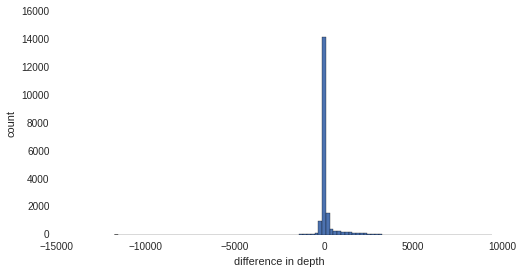

In [46]:
plt.hist(depths['depth_a']-depths['depth_b'], bins = 100)
plt.xlabel('difference in depth')
plt.ylabel('count')
plt.show()

Allelelic ratios

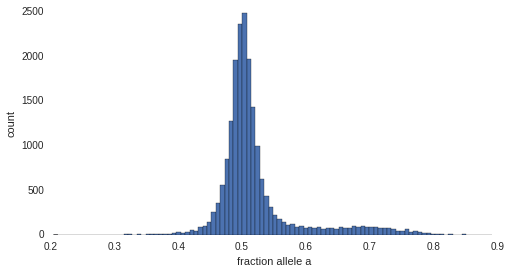

In [48]:
plt.hist(depths['ratio'], bins = 100)
plt.xlabel('fraction allele a')
plt.ylabel('count')
plt.show()

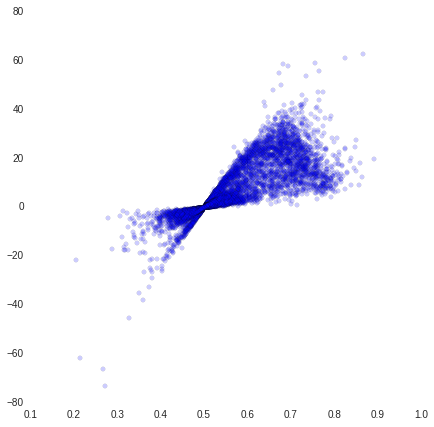

In [22]:
plt.scatter(depths['ratio'], depths['z'], alpha = .2)
plt.xlabel('fraction allele a')
plt.ylabel('z-score')
plt.show()

histogram of z-scores

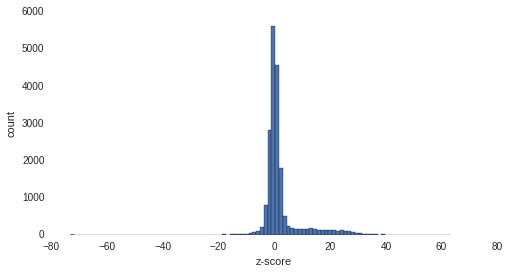

In [56]:
plt.hist(depths['z'], bins = 100)
plt.xlabel('z-score')
plt.ylabel('count')
plt.show()

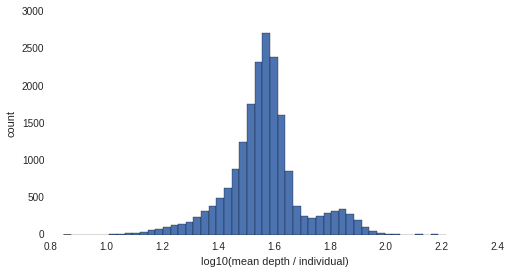

In [62]:
figsize(8,4)
#plt.xscale('log')
plt.hist(np.log10(depths['depth_per_het']), bins = 50)
plt.xlabel('log10(mean depth / individual) ')
plt.ylabel('count')
plt.show()

Higher depths leads to somewhat more bias

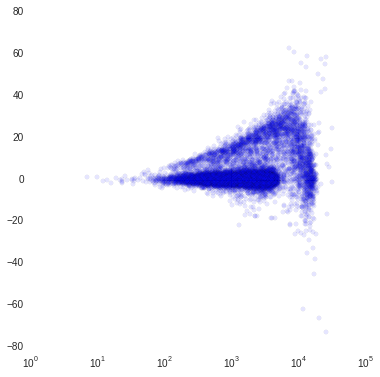

In [66]:
figsize(6,6)
plt.scatter(depths['total_depth'], depths['z'], alpha = .1)
plt.xscale('log')
plt.show()

In [109]:
non_dups = depths[depths['Duplicate']==1]
dups = depths[depths['Duplicate']==2]
unk = depths[depths['Duplicate']==0]

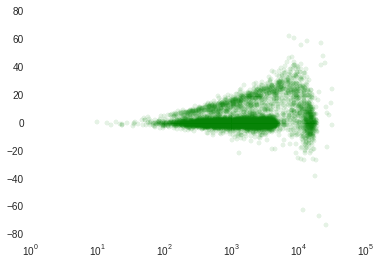

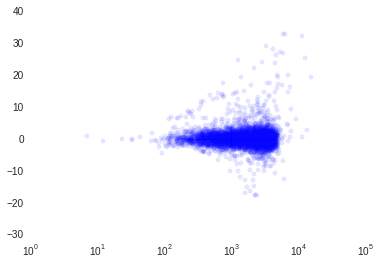

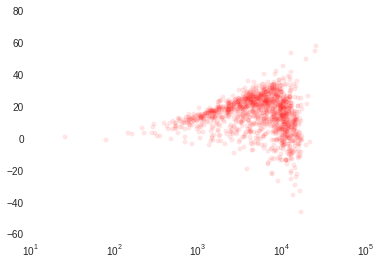

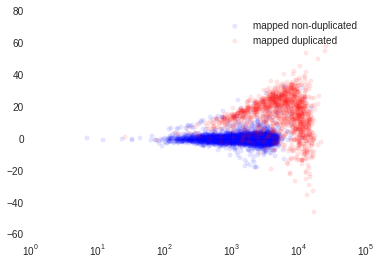

In [115]:
plt.scatter(unk['total_depth'], unk['z'], alpha = .1, color = 'green')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .1, color = 'blue')
plt.xscale('log')
plt.show()
plt.scatter(dups['total_depth'], dups['z'], alpha = .1, color = 'red')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['total_depth'], non_dups['z'], alpha = .1, color = 'blue', label = 'mapped non-duplicated')
plt.scatter(dups['total_depth'], dups['z'], alpha = .1, color = 'red', label = 'mapped duplicated')
plt.xscale('log')
plt.legend()
plt.show()

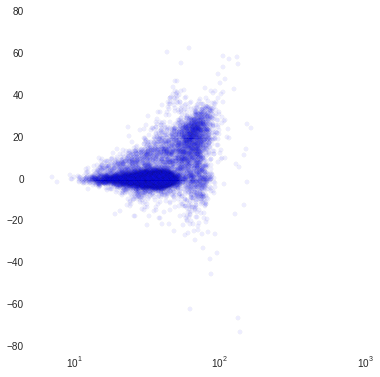

In [71]:
plt.scatter(depths['depth_per_het'], depths['z'], alpha = .07)
plt.xscale('log')
plt.xlim(5)
plt.show()

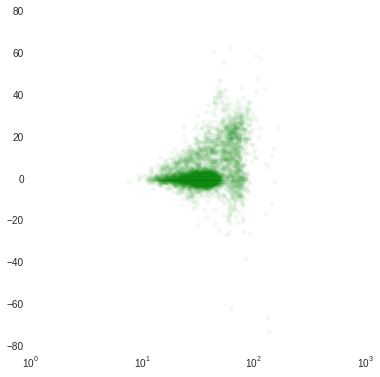

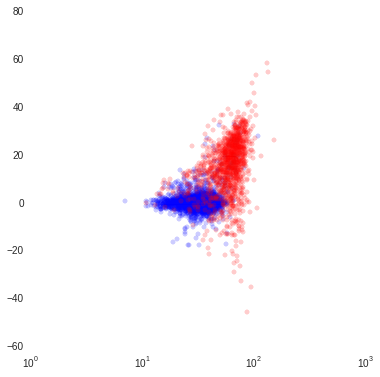

In [73]:
plt.scatter(unk['depth_per_het'], unk['z'], alpha = .05, color = 'green')
plt.xscale('log')
plt.show()
plt.scatter(non_dups['depth_per_het'], non_dups['z'], alpha = .2, color = 'blue')
plt.scatter(dups['depth_per_het'], dups['z'], alpha = .2, color = 'red')
plt.xscale('log')
plt.show()

In [31]:
depths.head(1)

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.5,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0


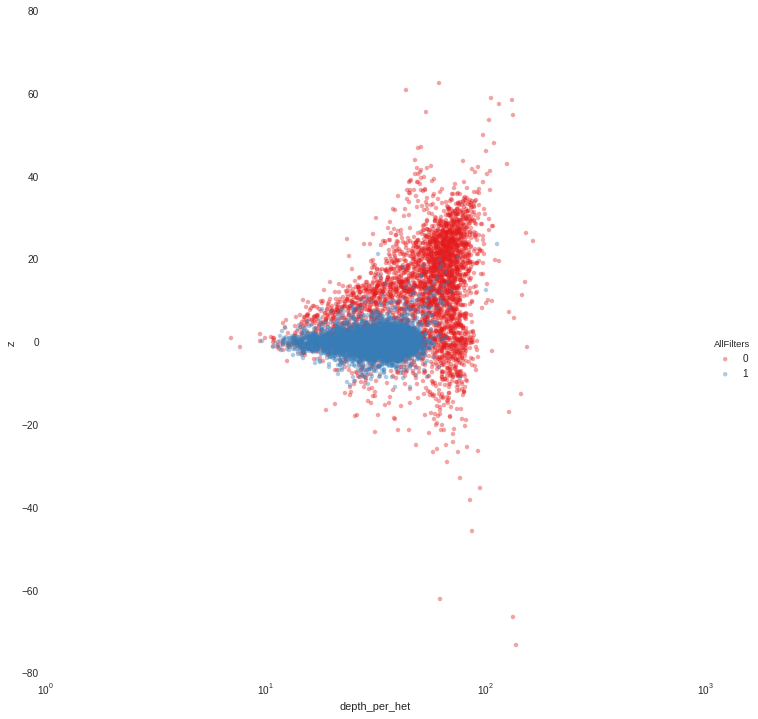

In [74]:
sns.lmplot(x = 'depth_per_het', y = 'z', data = depths, fit_reg = False, hue = 'AllFilters', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.4}, size =10)
plt.xscale('log')

plt.show()

In [33]:
depths.head(1)

,contgis,pos,locus_ID,depth_a,depth_b,ratio,num_hets,total_depth,depth_per_het,Duplicate,KnownDupRemoved,HWPassed,FisPassed,BiasRatio,MAF05_3pops,AllFilters_noMAF,AllFilters,std,z
0,un,161,11,177,177,0.5,9,354,39.333333,0,1,1,1,1,0,1,0,9.407444,-0


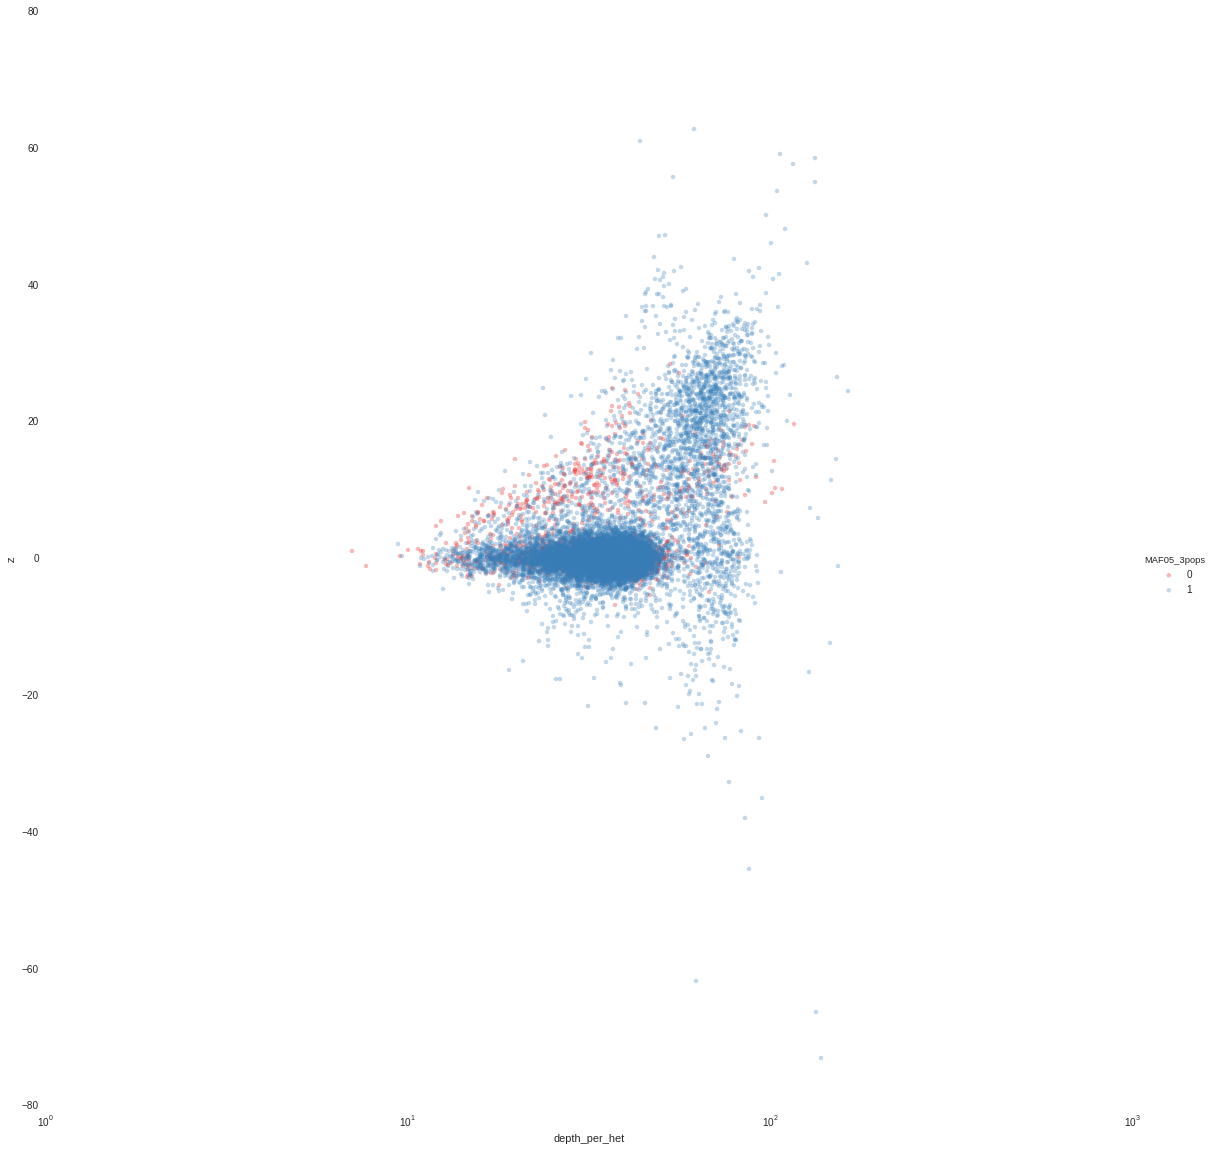

In [34]:
figsize(8,8)
sns.lmplot(x = 'depth_per_het', y = 'z', data = depths, fit_reg = False, hue = 'MAF05_3pops', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.3}, size =16)
plt.xscale('log')

plt.show()

No clear pattern of depth by position, maybe a slight trend down near the end of the reads.

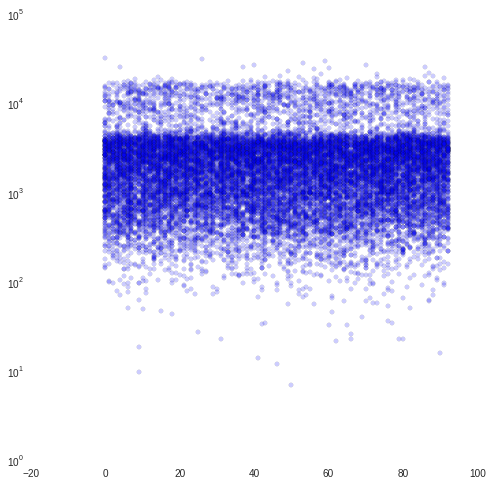

In [35]:
plt.scatter(depths['pos']%93, depths['total_depth'], alpha = .2)
plt.yscale('log')
plt.show()

How is the z-score related to the allelic ratio?

Bias by position

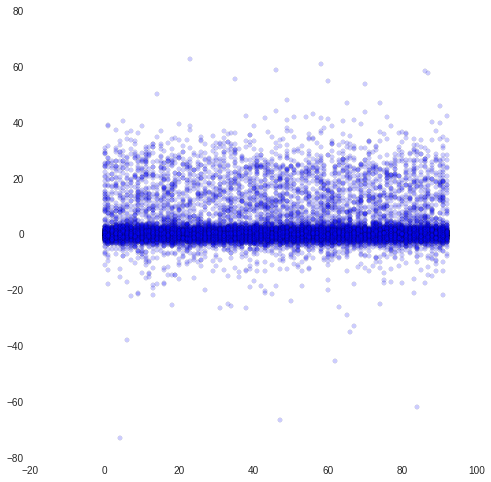

In [37]:
plt.scatter(depths['pos']%93, depths['z'], alpha = .2)
plt.show()

Relation to depth

#### qq plots

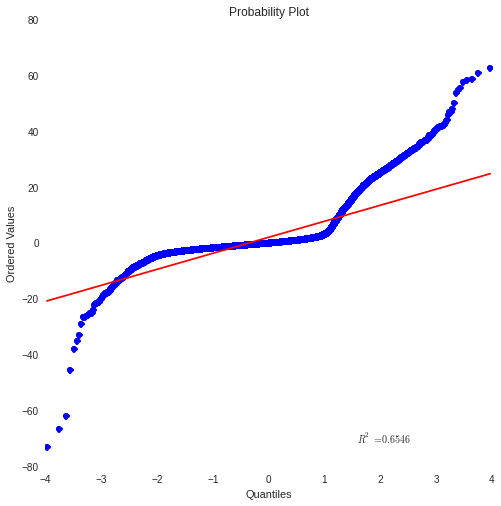

In [38]:
scipy.stats.probplot(depths['z'], dist="norm", plot=plt)
plt.show()

(-5, 5)

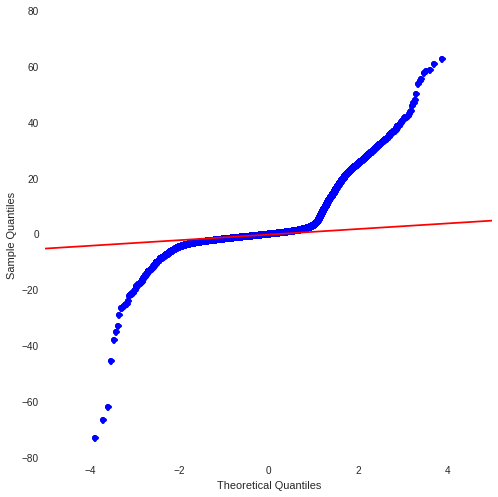

In [39]:
qq = statsmodels.graphics.gofplots.qqplot(depths['z'], line = '45')
plt.xlim(-5,5)

# BELOW IN PROGRESS

#### This will write out depth per locus per individual

In [2]:
from vcf_to_depth import vcf_to_allele_depth_by_ind

In [3]:
vcf_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.vcf.gz')
depths_file = os.path.join('..', 'data', 'chinook.batch10.singleSNP.depths_by_ind')

In [4]:
vcf_to_allele_depth_by_ind(vcf_file=vcf_file, out_file = depths_file)

skipped 9 header lines
found 216 individuals


In [27]:
ind_depths = pd.read_csv(depths_file, sep = '\t', header = None)
ind_depths.columns = ['contig', 'pos', 'locus_ID', 'ind', 'depth_a' , 'depth_b', 'std', 'z']
ind_depths['depth'] = ind_depths['depth_a'] + ind_depths['depth_b']
ind_depths['abs_z'] = np.abs(ind_depths['z'])
ind_depths.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z
0,un,161,11,KGONF06_0039,6,11,2.061553,-1.212678,17,1.212678
1,un,161,11,KGONF06_0047,7,8,1.936492,-0.258199,15,0.258199
2,un,161,11,KIOW10_0004,14,15,2.692582,-0.185695,29,0.185695
3,un,161,11,KIOW10_0048,34,29,3.968627,0.629941,63,0.629941
4,un,161,11,KKOGR07_0009,15,15,2.738613,-0.000000,30,0.000000


In [28]:
duplicate_status = pd.read_csv(os.path.join('..', 'data', 'chinook_DuplicateStatus.txt'), sep = '\t', header = 0)
duplicate_status.columns = ['locus_ID', 'Duplicate']
ind_depths = pd.merge(ind_depths, duplicate_status)
ind_depths.head()

,contig,pos,locus_ID,ind,depth_a,depth_b,std,z,depth,abs_z,Duplicate
0,un,161,11,KGONF06_0039,6,11,2.061553,-1.212678,17,1.212678,0
1,un,161,11,KGONF06_0047,7,8,1.936492,-0.258199,15,0.258199,0
2,un,161,11,KIOW10_0004,14,15,2.692582,-0.185695,29,0.185695,0
3,un,161,11,KIOW10_0048,34,29,3.968627,0.629941,63,0.629941,0
4,un,161,11,KKOGR07_0009,15,15,2.738613,-0.000000,30,0.000000,0


In [62]:
ind_depth_means = ind_depths.groupby('locus_ID').mean()

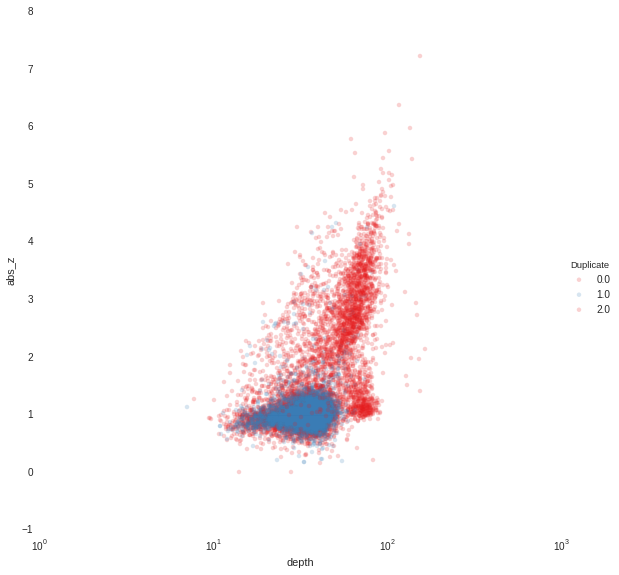

In [64]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_means, fit_reg = False, hue = 'Duplicate', 
           palette=sns.color_palette("Set1", 2), scatter_kws = {'alpha':.2}, size =8)
plt.xscale('log')

plt.show()

In [71]:
ind_depth_means = ind_depths.groupby('ind').mean()

ind_depth_means.head()
ind_depth_means['pop'] = [xx.split('_')[0] for xx in ind_depth_means.index.tolist()]

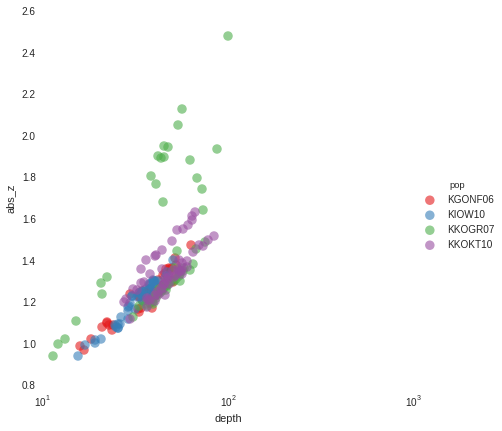

In [60]:
sns.lmplot(x = 'depth', y = 'abs_z', data = ind_depth_means, fit_reg = False, hue = 'pop', 
           palette=sns.color_palette("Set1", 4), scatter_kws = {'alpha':.6, 's':90}, size =6)
plt.xscale('log')

plt.show()